# Modeling

Purpose: The purpose of this notebook is to model the data created in my feature engineering notebooks.

### Notebook Outline

- Import Libraries
- Upload Data
- Create Win/Loss Target for 2019 Data
- Upload and Merge Kenpom Data
- Upload and Merge Massey Ordinals
- Upload and Merge TrueSkill Data
- Feature Engineering
    - Power Conference Feature
    - Create Win/Loss Target for Training Data
    - Create Team 1 and Team 2 Difference Features
    - Upload and Merge Top 25 Feature
    - Upload and Merge Distance and Elevation Features
- Modeling
    - Baseline LogReg Model
    - Iterating to Improve Model
    - XGBoost
    - XGBoostClassifier

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)

### Upload Data

In [2]:
tourney_data = pd.read_csv('Data/tourney_data.csv')

In [3]:
results_2019 = pd.read_csv('Data/results_2019.csv')

In [4]:
results_2019.head()

,Season,T1_TeamID,T2_TeamID,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2019,1192,1341,1,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,1.000000,1.000000,16,16,0
1,2019,1125,1396,1,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,0.500000,0.666667,11,11,0
2,2019,1295,1300,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,1.000000,0.750000,16,16,0
3,2019,1113,1385,1,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,77.515152,74.787879,27.939394,61.545455,8.515152,23.575758,13.121212,18.090909,7.636364,24.909091,14.030303,10.363636,8.818182,3.333333,19.060606,25.181818,57.939394,8.424242,24.727273,16.000000,22.606061,10.545455,28.121212,13.636364,15.454545,5.181818,2.424242,17.000000,2.727273,0.666667,0.333333,11,11,0
4,2019,1181,1295,1,83.500000,67.558824,30.500000,63.911765,7.264706,24.058824,15.235294,22.088235,13.382353,28.382353,15.911765,13.117647,9.470588,6.823529,15.852941,25.235294,63.852941,6.500000,22.117647,10.588235,15.323529,11.970588,23.676471,12.294118,14.764706,6.529412,3.176471,17.676471,15.941176,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.

### Create Win/Loss Target for Test Data

In [5]:
results_2019_2 = results_2019.copy()

In [6]:
results_2019_2.columns = ['Season', 'T2_TeamID', 'T1_TeamID', 'win', 'T2_Scoremean', 'T2_opponent_Scoremean', 
                          'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_FTMmean', 'T2_FTAmean', 
                          'T2_ORmean', 'T2_DRmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean', 
                          'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean', 'T2_opponent_FGM3mean', 
                          'T2_opponent_FGA3mean', 'T2_opponent_FTMmean', 'T2_opponent_FTAmean', 'T2_opponent_ORmean', 
                          'T2_opponent_DRmean', 'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean', 
                          'T2_opponent_Blkmean', 'T2_opponent_PFmean', 'T2_PointDiffmean', 'T1_Scoremean', 
                          'T1_opponent_Scoremean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 
                          'T1_FTMmean', 'T1_FTAmean', 'T1_ORmean', 'T1_DRmean', 'T1_Astmean', 'T1_TOmean', 
                          'T1_Stlmean', 'T1_Blkmean', 'T1_PFmean', 'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 
                          'T1_opponent_FGM3mean', 'T1_opponent_FGA3mean', 'T1_opponent_FTMmean', 
                          'T1_opponent_FTAmean', 'T1_opponent_ORmean', 'T1_opponent_DRmean', 'T1_opponent_Astmean', 
                          'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean', 'T1_opponent_PFmean', 
                          'T1_PointDiffmean', 'T2_win_ratio_14d', 'T1_win_ratio_14d', 'T2_seed', 'T1_seed', 
                          'Seed_diff']

In [7]:
results_2019_2 = results_2019_2 [['Season', 'T1_TeamID', 'T2_TeamID', 'win', 'T1_Scoremean', 'T1_opponent_Scoremean', 
                          'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_FTMmean', 'T1_FTAmean', 
                          'T1_ORmean', 'T1_DRmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_Blkmean', 
                          'T1_PFmean', 'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean', 
                          'T1_opponent_FGA3mean', 'T1_opponent_FTMmean', 'T1_opponent_FTAmean', 'T1_opponent_ORmean', 
                          'T1_opponent_DRmean', 'T1_opponent_Astmean', 'T1_opponent_TOmean', 'T1_opponent_Stlmean', 
                          'T1_opponent_Blkmean', 'T1_opponent_PFmean', 'T1_PointDiffmean', 'T2_Scoremean', 
                          'T2_opponent_Scoremean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 
                          'T2_FTMmean', 'T2_FTAmean', 'T2_ORmean', 'T2_DRmean', 'T2_Astmean', 'T2_TOmean', 
                          'T2_Stlmean', 'T2_Blkmean', 'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean', 
                          'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_FTMmean', 
                          'T2_opponent_FTAmean', 'T2_opponent_ORmean', 'T2_opponent_DRmean', 'T2_opponent_Astmean', 
                          'T2_opponent_TOmean', 'T2_opponent_Stlmean', 'T2_opponent_Blkmean', 'T2_opponent_PFmean', 
                          'T2_PointDiffmean', 'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_seed', 'T2_seed', 
                          'Seed_diff']]

In [8]:
results_2019_2['Seed_diff'] = results_2019_2['Seed_diff'] * -1

In [9]:
results_2019_2.head()

,Season,T1_TeamID,T2_TeamID,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2019,1341,1192,1,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,1.000000,1.000000,16,16,0
1,2019,1396,1125,1,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,0.666667,0.500000,11,11,0
2,2019,1300,1295,1,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,0.750000,1.000000,16,16,0
3,2019,1385,1113,1,77.515152,74.787879,27.939394,61.545455,8.515152,23.575758,13.121212,18.090909,7.636364,24.909091,14.030303,10.363636,8.818182,3.333333,19.060606,25.181818,57.939394,8.424242,24.727273,16.000000,22.606061,10.545455,28.121212,13.636364,15.454545,5.181818,2.424242,17.000000,2.727273,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,0.333333,0.666667,11,11,0
4,2019,1295,1181,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,83.500000,67.558824,30.500000,63.911765,7.264706,24.058824,15.235294,22.088235,13.382353,28.382353,15.911765,13.117647,9.470588,6.823529,15.852941,25.235294,63.852941,6.500000,22.117647,10.588235,15.323529,11.970588,23.676471,12.294118,14.764706,6.529412,3.176471,17.

In [10]:
results_2019_2.loc[results_2019_2['win'] == 0, 'win'] = -1
results_2019_2.loc[results_2019_2['win'] == 1, 'win'] = 0

results_2019_2.loc[results_2019_2['win'] == -1, 'win'] = 1

In [11]:
results_2019_2['win']

0     0
1     0
2     0
3     0
4     0
     ..
62    1
63    0
64    1
65    1
66    1
Name: win, Length: 67, dtype: int64

In [12]:
results_2019_2['win'].value_counts()

1    37
0    30
Name: win, dtype: int64

In [13]:
results_2019.head()

,Season,T1_TeamID,T2_TeamID,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2019,1192,1341,1,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,1.000000,1.000000,16,16,0
1,2019,1125,1396,1,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,0.500000,0.666667,11,11,0
2,2019,1295,1300,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,1.000000,0.750000,16,16,0
3,2019,1113,1385,1,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,77.515152,74.787879,27.939394,61.545455,8.515152,23.575758,13.121212,18.090909,7.636364,24.909091,14.030303,10.363636,8.818182,3.333333,19.060606,25.181818,57.939394,8.424242,24.727273,16.000000,22.606061,10.545455,28.121212,13.636364,15.454545,5.181818,2.424242,17.000000,2.727273,0.666667,0.333333,11,11,0
4,2019,1181,1295,1,83.500000,67.558824,30.500000,63.911765,7.264706,24.058824,15.235294,22.088235,13.382353,28.382353,15.911765,13.117647,9.470588,6.823529,15.852941,25.235294,63.852941,6.500000,22.117647,10.588235,15.323529,11.970588,23.676471,12.294118,14.764706,6.529412,3.176471,17.676471,15.941176,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.

In [14]:
results_2019_2.head()

,Season,T1_TeamID,T2_TeamID,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2019,1341,1192,0,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,1.000000,1.000000,16,16,0
1,2019,1396,1125,0,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,0.666667,0.500000,11,11,0
2,2019,1300,1295,0,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,0.750000,1.000000,16,16,0
3,2019,1385,1113,0,77.515152,74.787879,27.939394,61.545455,8.515152,23.575758,13.121212,18.090909,7.636364,24.909091,14.030303,10.363636,8.818182,3.333333,19.060606,25.181818,57.939394,8.424242,24.727273,16.000000,22.606061,10.545455,28.121212,13.636364,15.454545,5.181818,2.424242,17.000000,2.727273,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,0.333333,0.666667,11,11,0
4,2019,1295,1181,0,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,83.500000,67.558824,30.500000,63.911765,7.264706,24.058824,15.235294,22.088235,13.382353,28.382353,15.911765,13.117647,9.470588,6.823529,15.852941,25.235294,63.852941,6.500000,22.117647,10.588235,15.323529,11.970588,23.676471,12.294118,14.764706,6.529412,3.176471,17.

In [15]:
results_2019 = pd.concat([results_2019, results_2019_2])

In [17]:
results_2019.head()

,Season,T1_TeamID,T2_TeamID,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2019,1192,1341,1,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,1.000000,1.000000,16,16,0
1,2019,1125,1396,1,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,0.500000,0.666667,11,11,0
2,2019,1295,1300,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,1.000000,0.750000,16,16,0
3,2019,1113,1385,1,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,77.515152,74.787879,27.939394,61.545455,8.515152,23.575758,13.121212,18.090909,7.636364,24.909091,14.030303,10.363636,8.818182,3.333333,19.060606,25.181818,57.939394,8.424242,24.727273,16.000000,22.606061,10.545455,28.121212,13.636364,15.454545,5.181818,2.424242,17.000000,2.727273,0.666667,0.333333,11,11,0
4,2019,1181,1295,1,83.500000,67.558824,30.500000,63.911765,7.264706,24.058824,15.235294,22.088235,13.382353,28.382353,15.911765,13.117647,9.470588,6.823529,15.852941,25.235294,63.852941,6.500000,22.117647,10.588235,15.323529,11.970588,23.676471,12.294118,14.764706,6.529412,3.176471,17.676471,15.941176,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.

In [18]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,NaN,NaN,16,16,0
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,NaN,NaN,1,16,-15
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,NaN,NaN,10,7,3
3,2003,136,1141,79,1166,73,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,19.275862,25.172414,10.586207,23.275862,15.620690,18.241379,7.103448,4.000000,20.965517,26.344828,57.931034,4.965517,13.896552,15.586207,21.965517,12.241379,18.896552,11.793103,16.068966,8.448276,2.482759,21.689655,6.103448,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,13.878788,20.030303,10.878788,23.181818,16.818182,13.363636,8.393939,4.454545,17.272727,23.878788,55.333333,4.878788,14.303030,11.696970,16.696970,11.060606,21.363636,12.363636,17.060606,6.333333,2.575758,19.393939,14.909091,1.000000,1.000000,NaN,NaN,11,6,5
4,2003,136,1143,76,1301,74,74.482759,69.758621,27.344828,58.724138,6.413793,17.034483,13.379310,19.517241,11.241379,24.379310,16.000000,14.172414,6.551724,2.793103,17.103448,25.379310,58.793103,7.103448,21.448276,11.896552,17.448276,11.172414,23.000000,16.034483,14.931034,5.931034,2.517241,19.103448,4.724138,72.400000,68.000000,24.333333,53.333333,7.966667,22.500000,15.766667,20.466667,9.733333,22.033333,14.666667,14.200000,7.766667,3.066667,18.66666

In [19]:
tourney_data.shape

(2096, 71)

### Upload and Merge Kenpom Data

There is a website called [Kenpom](www.kenpom.com) that has advanced college basketball metrics that I decided to use for my project. A user uploaded some scraped data to Kaggle, which I used. The values that the data set contained were adjusted offensive efficiency (adjo), adjust defensive efficiency (adjd), adjusted net efficiency (adjem), and luck.

In [20]:
kenpom = pd.read_csv('Data/kenpom_2020.csv')

In [21]:
kenpom = kenpom[kenpom['Season'] != 2020]

In [22]:
kenpom.head()

,team,conf,adjem,adjo,adjd,luck,Season,TeamID
451,virginia,ACC,35.66,123.6,87.9,0.024,2019,1438
452,gonzaga,WCC,32.79,125.1,92.3,0.008,2019,1211
453,duke,ACC,31.99,120.1,88.1,0.018,2019,1181
454,michigan st.,B10,31.36,121.7,90.4,-0.007,2019,1277
455,michigan,B10,29.44,115.5,86.1,-0.014,2019,1276


In [23]:
len(kenpom['TeamID'].unique())

357

In [24]:
kenpom = kenpom[['Season', 'TeamID', 'conf', 'adjem', 'adjo', 'adjd', 'luck']]

In [25]:
kenpom.shape

(7837, 7)

In [26]:
kenpom = kenpom.drop_duplicates(keep = 'first')

In [27]:
kenpom_T1 = kenpom.copy()
kenpom_T2 = kenpom.copy()
kenpom_T1.columns = ['Season', 'T1_TeamID', 'T1_conf', 'T1_adjem', 'T1_adjo', 'T1_adjd', 'T1_luck']
kenpom_T2.columns = ['Season', 'T2_TeamID', 'T2_conf', 'T2_adjem', 'T2_adjo', 'T2_adjd', 'T2_luck']

In [28]:
kenpom_T1.shape

(6157, 7)

In [29]:
tourney_data = pd.merge(tourney_data, kenpom_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, kenpom_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [30]:
results_2019 = pd.merge(results_2019, kenpom_T1, on = ['Season', 'T1_TeamID'], how = 'left')
results_2019 = pd.merge(results_2019, kenpom_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [31]:
tourney_data.shape

(2096, 81)

### Upload and Merge Massey Ordinals

The Massey Ordinals dataset was provided by the Kaggle competition. It is a dataset that I prepared in a separate notebook.

In [32]:
massey_df = pd.read_csv('Data/massey_df.csv')

In [33]:
massey_df.head()

,Season,TeamID,POM_Rating,SAG_Rating,MOR_Rating,WLK_Rating,massey_avg
0,2003,1102,72.401655,73.184732,74.438603,72.052049,73.019260
1,2003,1103,72.191443,71.568652,73.915248,71.568652,72.310999
2,2003,1104,84.394558,83.767837,85.634834,83.919965,84.429299
3,2003,1105,63.125055,62.833369,63.008256,62.949919,62.979150
4,2003,1106,65.741658,65.439336,63.888462,66.289491,65.339737


In [34]:
massey_2019 = massey_df[massey_df['Season'] == 2019]

In [35]:
teams = pd.read_csv('Data/Stage2DataFiles/Teams.csv')

In [38]:
massey_2019 = pd.merge(massey_2019, teams, on = ['TeamID'], how = 'left')

In [39]:
massey_2019.sort_values(by = 'massey_avg', ascending = False)

,Season,TeamID,POM_Rating,SAG_Rating,MOR_Rating,WLK_Rating,massey_avg,TeamName,FirstD1Season,LastD1Season
326,2019,1438,97.181957,97.181957,94.318459,97.181957,96.466082,Virginia,1985,2019
104,2019,1211,95.514642,95.514642,97.181957,94.318459,95.632425,Gonzaga,1985,2019
74,2019,1181,94.318459,94.318459,95.514642,95.514642,94.916550,Duke,1985,2019
204,2019,1314,92.605689,93.380430,93.380430,93.380430,93.186745,North Carolina,1985,2019
169,2019,1277,93.380430,92.605689,92.605689,92.605689,92.799375,Michigan St,1985,2019
...,...,...,...,...,...,...,...,...,...,...
310,2019,1421,60.818463,60.932427,60.534128,60.704631,60.747412,UNC Asheville,1987,2019
181,2019,1290,60.647764,60.647764,60.590930,60.647764,60.633556,MS Valley St,1985,2019
163,2019,1271,60.534128,60.590930,60.761530,60.590930,60.619379,MD E Shore,1985,2019
45,2019,1152,60.590930,60.534128,60.477358,60.534128,60.534136,Chicago St,1985,2019


In [40]:
massey_T1 = massey_df.copy()
massey_T2 = massey_df.copy()
massey_T1.columns = ['Season', 'T1_TeamID', 'T1_POM', 'T1_SAG', 'T1_MOR', 'T1_WLK', 'T1_massey_avg']
massey_T2.columns = ['Season', 'T2_TeamID', 'T2_POM', 'T2_SAG', 'T2_MOR', 'T2_WLK', 'T2_massey_avg']

In [41]:
tourney_data = pd.merge(tourney_data, massey_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, massey_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [42]:
results_2019 = pd.merge(results_2019, massey_T1, on = ['Season', 'T1_TeamID'], how = 'left')
results_2019 = pd.merge(results_2019, massey_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [43]:
tourney_data.shape

(2096, 91)

In [44]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_conf,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_conf,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,NaN,NaN,16,16,0,BSth,-12.35,101.2,113.5,0.119,SWAC,-10.45,98.3,108.7,0.037,65.138397,66.473193,64.898606,67.338190,65.962096,65.439336,66.106343,63.947499,67.151721,65.661225
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,NaN,NaN,1,16,-15,P10,26.80,115.6,88.8,-0.007,AE,1.57,101.1,99.5,0.019,94.318459,95.514642,93.380430,95.514642,94.682043,73.547610,72.542565,70.554232,72.897644,72.385513
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,NaN,NaN,10,7,3,P10,16.49,113.9,97.4,-0.014,CUSA,16.72,110.9,94.1,0.005,84.559424,84.559424,86.458023,84.233153,84.952506,86.912819,86.033588,86.242330,86.681285,86.467505
3,2003,136,1141,79,1166,73,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,19.275862,25.172414,10.586207,23.275862,15.620690,18.241379,7.103448,4.000000,20.965517,26.344828,57.931034,4.965517,13.896552,15.586207,21.965517,12.241379,18.896552,11.793103,16.068966,8.448276,2.482759,21.689655,6.103448,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,13.878788,20.030303,10.878788,23.181818,16.818182,13.363636,8.393939,4.454545,

### Upload and Merge TrueSkill Data

In [45]:
trueskill_df = pd.read_csv('Data/TrueSkill.csv')

In [46]:
trueskill_T1 = trueskill_df.copy()
trueskill_T2 = trueskill_df.copy()
trueskill_T1.columns = ['Season', 'T1_TeamID', 'T1_Trueskill']
trueskill_T2.columns = ['Season', 'T2_TeamID', 'T2_Trueskill']

In [47]:
tourney_data.shape

(2096, 91)

In [48]:
tourney_data = pd.merge(tourney_data, trueskill_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, trueskill_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [49]:
results_2019 = pd.merge(results_2019, trueskill_T1, on = ['Season', 'T1_TeamID'], how = 'left')
results_2019 = pd.merge(results_2019, trueskill_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [50]:
tourney_data.shape

(2096, 93)

In [51]:
index = list(range(len(tourney_data)))

### Feature Engineering

Create a power conference feature. This feature will be binary, 1 for being in a power conference (ACC, Big 12, Big 10, Pac 10/12, and the SEC), 0 if not. 

In [52]:
power_conference = []
for i in index:
    if tourney_data['T1_conf'][i] == 'ACC':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T1_conf'][i] == 'B12':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T1_conf'][i] == 'B10':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T1_conf'][i] == 'P12':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T1_conf'][i] == 'P10':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T1_conf'][i] == 'SEC':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    else:
        pc = {'T1_power_c' : 0}
        power_conference.append(pc)

In [53]:
df = pd.DataFrame(power_conference)

In [54]:
tourney_data['T1_power_c'] = df

In [55]:
index = list(range(len(results_2019)))

In [56]:
power_conference = []
for i in index:
    if results_2019['T1_conf'][i] == 'ACC':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T1_conf'][i] == 'B12':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T1_conf'][i] == 'B10':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T1_conf'][i] == 'P12':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T1_conf'][i] == 'P10':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T1_conf'][i] == 'SEC':
        pc = {'T1_power_c' : 1}
        power_conference.append(pc)
    else:
        pc = {'T1_power_c' : 0}
        power_conference.append(pc)

In [57]:
df = pd.DataFrame(power_conference)

In [58]:
results_2019['T1_power_c'] = df

In [59]:
index = list(range(len(tourney_data)))

In [60]:
power_conference = []
for i in index:
    if tourney_data['T2_conf'][i] == 'ACC':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T1_conf'][i] == 'B12':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T2_conf'][i] == 'B10':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T2_conf'][i] == 'P12':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T2_conf'][i] == 'P10':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif tourney_data['T2_conf'][i] == 'SEC':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    else:
        pc = {'T2_power_c' : 0}
        power_conference.append(pc)

In [61]:
df = pd.DataFrame(power_conference)

In [62]:
tourney_data['T2_power_c'] = df

In [63]:
index = list(range(len(results_2019)))

In [64]:
power_conference = []
for i in index:
    if results_2019['T2_conf'][i] == 'ACC':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T1_conf'][i] == 'B12':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T2_conf'][i] == 'B10':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T2_conf'][i] == 'P12':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T2_conf'][i] == 'P10':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    elif results_2019['T2_conf'][i] == 'SEC':
        pc = {'T2_power_c' : 1}
        power_conference.append(pc)
    else:
        pc = {'T2_power_c' : 0}
        power_conference.append(pc)

In [65]:
df = pd.DataFrame(power_conference)

In [66]:
results_2019['T2_power_c'] = df

In [67]:
tourney_data = tourney_data.drop(['T1_conf', 'T2_conf', 'T1_quality', 'T2_quality'], axis=1)

In [68]:
results_2019 = results_2019.drop(['T1_conf', 'T2_conf'], axis=1)

In [69]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,16,16,0,-12.35,101.2,113.5,0.119,-10.45,98.3,108.7,0.037,65.138397,66.473193,64.898606,67.338190,65.962096,65.439336,66.106343,63.947499,67.151721,65.661225,22.040687,19.170459,0,0
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,1,16,-15,26.80,115.6,88.8,-0.007,1.57,101.1,99.5,0.019,94.318459,95.514642,93.380430,95.514642,94.682043,73.547610,72.542565,70.554232,72.897644,72.385513,38.633989,24.827440,1,0
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,10,7,3,16.49,113.9,97.4,-0.014,16.72,110.9,94.1,0.005,84.559424,84.559424,86.458023,84.233153,84.952506,86.912819,86.033588,86.242330,86.681285,86.467505,32.653121,35.015742,1,0
3,2003,136,1141,79,1166,73,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,19.275862,25.172414,10.586207,23.275862,15.620690,18.241379,7.103448,4.000000,20.965517,26.344828,57.931034,4.965517,13.896552,15.586207,21.965517,12.241379,18.896552,11.793103,16.068966,8.448276,2.482759,21.689655,6.103448,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,13.878788,20.030303,10.878788,23.181818,16.818

Create Win/Loss target feature. If Team 1 won this particular game, the win column will be a 1, 0 if Team 1 lost.

In [70]:
tourney_data['pt_diff'] = tourney_data['T1_Score'] - tourney_data['T2_Score']

In [71]:
win_loss = []
index = list(range(len(tourney_data)))

for i in index:
    if tourney_data['pt_diff'][i] > 0:
        w_l = {'win' : 1}
        win_loss.append(w_l)
    else:
        w_l = {'win' : 0}
        win_loss.append(w_l)

In [72]:
df = pd.DataFrame(win_loss)

In [73]:
tourney_data['win'] = df

In [74]:
tourney_data.shape

(2096, 93)

This creates some features that find the difference between Team 1 and Team 2 features.

In [75]:
tourney_data['ave_pt_diff'] = tourney_data['T1_PointDiffmean'] - tourney_data['T2_PointDiffmean']

In [76]:
results_2019['ave_pt_diff'] = results_2019['T1_PointDiffmean'] - results_2019['T2_PointDiffmean']

In [77]:
tourney_data['adjem_diff'] = tourney_data['T1_adjem'] - tourney_data['T2_adjem']

In [78]:
results_2019['adjem_diff'] = results_2019['T1_adjem'] - results_2019['T2_adjem']

In [79]:
tourney_data['adjo_diff'] = tourney_data['T1_adjo'] - tourney_data['T2_adjo']

In [80]:
results_2019['adjo_diff'] = results_2019['T1_adjo'] - results_2019['T2_adjo']

In [81]:
tourney_data['adjd_diff'] = tourney_data['T1_adjd'] - tourney_data['T2_adjd']

In [82]:
results_2019['adjd_diff'] = results_2019['T1_adjd'] - results_2019['T2_adjd']

In [83]:
tourney_data['luck_diff'] = tourney_data['T1_luck'] - tourney_data['T2_luck']

In [84]:
results_2019['luck_diff'] = results_2019['T1_luck'] - results_2019['T2_luck']

In [85]:
tourney_data['pom_diff'] = tourney_data['T1_POM'] - tourney_data['T2_POM']

In [86]:
results_2019['pom_diff'] = results_2019['T1_POM'] - results_2019['T2_POM']

In [87]:
tourney_data['massey_avg_diff'] = tourney_data['T1_massey_avg'] - tourney_data['T2_massey_avg']

In [88]:
results_2019['massey_avg_diff'] = results_2019['T1_massey_avg'] - results_2019['T2_massey_avg']

In [89]:
tourney_data['trueskill_diff'] = tourney_data['T1_Trueskill'] - tourney_data['T2_Trueskill']

In [90]:
results_2019['trueskill_diff'] = results_2019['T1_Trueskill'] - results_2019['T2_Trueskill']

In [91]:
tourney_data['TO_diff'] = tourney_data['T1_TOmean'] - tourney_data['T2_TOmean']

In [92]:
results_2019['TO_diff'] = results_2019['T1_TOmean'] - results_2019['T2_TOmean']

In [93]:
tourney_data['Block_diff'] = tourney_data['T1_Blkmean'] - tourney_data['T2_Blkmean']
results_2019['Block_diff'] = results_2019['T1_Blkmean'] - results_2019['T2_Blkmean']

In [94]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c,pt_diff,win,ave_pt_diff,adjem_diff,adjo_diff,adjd_diff,luck_diff,pom_diff,massey_avg_diff,trueskill_diff,TO_diff,Block_diff
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,16,16,0,-12.35,101.2,113.5,0.119,-10.45,98.3,108.7,0.037,65.138397,66.473193,64.898606,67.338190,65.962096,65.439336,66.106343,63.947499,67.151721,65.661225,22.040687,19.170459,0,0,8,1,-9.208046,-1.90,2.9,4.8,0.082,-0.300940,0.300871,2.870228,0.973563,0.766667
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,1,16,-15,26.80,115.6,88.8,-0.007,1.57,101.1,99.5,0.019,94.318459,95.514642,93.380430,95.514642,94.682043,73.547610,72.542565,70.554232,72.897644,72.385513,38.633989,24.827440,1,0,29,1,10.309113,25.23,14.5,-10.7,-0.026,20.770848,22.296530,13.806549,0.716749,1.248768
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,10,7,3,16.49,113.9,97.4,-0.014,16.72,110.9,94.1,0.005,84.559424,84.559424,86.458023,84.233153,84.952506,86.912819,86.033588,86.242330,86.681285,86.467505,32.653121,35.015742,1,0,13,1,-1.896552,-0.23,3.0,3.3,-0.019,-2.353395,-1.514999,-2.362621,0.206897,-0.827586
3,2003,136,1141,79,1166,73,79.344828,73

In [95]:
results_2019.head()

,Season,T1_TeamID,T2_TeamID,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c,ave_pt_diff,adjem_diff,adjo_diff,adjd_diff,luck_diff,pom_diff,massey_avg_diff,trueskill_diff,TO_diff,Block_diff
0,2019,1192,1341,1,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,1.000000,1.000000,16,16,0,-4.25,106.2,110.4,0.010,-4.31,101.5,105.8,0.074,68.280404,67.964436,73.401906,69.240757,69.721876,68.217052,67.151721,67.525294,68.726159,67.905057,22.514956,22.647360,0,0,0.136852,0.06,4.7,4.6,-0.064,0.063352,1.816819,-0.132403,0.845552,2.039101
1,2019,1125,1396,1,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,0.500000,0.666667,11,11,0,13.07,114.8,101.8,0.041,9.39,108.9,99.5,0.065,81.634973,80.940804,81.999970,81.755196,81.582736,79.869655,80.286836,80.829232,80.940804,80.481632,31.616110,34.151176,0,0,8.512500,3.68,5.9,2.3,-0.024,1.765318,1.101104,-2.535066,0.443750,1.550000
2,2019,1295,1300,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,1.000000,0.750000,16,16,0,-3.20,106.6,109.8,0.052,-11.89,96.6,108.5,0.004,69.240757,69.370314,66.842310,69.565358,68.754685,62.891624,62.949919,63.652771,63.829471,63.330946,22.673992,17.334198,0,0,-1.284946,8.69,10.0,1.3,0.048,6.349133,5.423738,5.339794,-4.854839,-0.082796
3,2019,1113,1385,1,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.59375

In [96]:
team_names = teams[['TeamID', 'TeamName']]

In [97]:
team_names_T1 = team_names.copy()
team_names_T2 = team_names.copy()
team_names_T1.columns = ['T1_TeamID', 'T1_TeamName']
team_names_T2.columns = ['T2_TeamID', 'T2_TeamName']

In [98]:
results_2019 = pd.merge(results_2019, team_names_T1, on = ['T1_TeamID'], how = 'left')
results_2019 = pd.merge(results_2019, team_names_T2, on = ['T2_TeamID'], how = 'left')

In [99]:
results_2019

,Season,T1_TeamID,T2_TeamID,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c,ave_pt_diff,adjem_diff,adjo_diff,adjd_diff,luck_diff,pom_diff,massey_avg_diff,trueskill_diff,TO_diff,Block_diff,T1_TeamName,T2_TeamName
0,2019,1192,1341,1,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,1.000000,1.000000,16,16,0,-4.25,106.2,110.4,0.010,-4.31,101.5,105.8,0.074,68.280404,67.964436,73.401906,69.240757,69.721876,68.217052,67.151721,67.525294,68.726159,67.905057,22.514956,22.647360,0,0,0.136852,0.06,4.7,4.6,-0.064,0.063352,1.816819,-0.132403,0.845552,2.039101,F Dickinson,Prairie View
1,2019,1125,1396,1,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,0.500000,0.666667,11,11,0,13.07,114.8,101.8,0.041,9.39,108.9,99.5,0.065,81.634973,80.940804,81.999970,81.755196,81.582736,79.869655,80.286836,80.829232,80.940804,80.481632,31.616110,34.151176,0,0,8.512500,3.68,5.9,2.3,-0.024,1.765318,1.101104,-2.535066,0.443750,1.550000,Belmont,Temple
2,2019,1295,1300,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,1.000000,0.750000,16,16,0,-3.20,106.6,109.8,0.052,-11.89,96.6,108.5,0.004,69.240757,69.370314,66.842310,69.565358,68.754685,62.891624,62.949919,63.652771,63.829471,63.330946,22.673992,17.334198,0,0,-1.284946,8.69,10.0,1.3,0.048,6.349133,5.423738,5.339794,-4.854839,-0.082796,N Dakota St,NC Central
3,2019,1113,1385,1,77.812500,73.062500,

In [100]:
# get a list of columns
cols = list(results_2019)
# move the column to head of list using index, pop and insert
cols.insert(2, cols.pop(cols.index('T1_TeamName')))
cols

# use ix to reorder
results_2019 = results_2019.ix[:, cols]
results_2019

/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,Season,T1_TeamID,T1_TeamName,T2_TeamID,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c,ave_pt_diff,adjem_diff,adjo_diff,adjd_diff,luck_diff,pom_diff,massey_avg_diff,trueskill_diff,TO_diff,Block_diff,T2_TeamName
0,2019,1192,F Dickinson,1341,1,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,1.000000,1.000000,16,16,0,-4.25,106.2,110.4,0.010,-4.31,101.5,105.8,0.074,68.280404,67.964436,73.401906,69.240757,69.721876,68.217052,67.151721,67.525294,68.726159,67.905057,22.514956,22.647360,0,0,0.136852,0.06,4.7,4.6,-0.064,0.063352,1.816819,-0.132403,0.845552,2.039101,Prairie View
1,2019,1125,Belmont,1396,1,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,0.500000,0.666667,11,11,0,13.07,114.8,101.8,0.041,9.39,108.9,99.5,0.065,81.634973,80.940804,81.999970,81.755196,81.582736,79.869655,80.286836,80.829232,80.940804,80.481632,31.616110,34.151176,0,0,8.512500,3.68,5.9,2.3,-0.024,1.765318,1.101104,-2.535066,0.443750,1.550000,Temple
2,2019,1295,N Dakota St,1300,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,1.000000,0.750000,16,16,0,-3.20,106.6,109.8,0.052,-11.89,96.6,108.5,0.004,69.240757,69.370314,66.842310,69.565358,68.754685,62.891624,62.949919,63.652771,63.829471,63.330946,22.673992,17.334198,0,0,-1.284946,8.69,10.0,1.3,0.048,6.349133,5.423738,5.339794,-4.854839,-0.082796,NC Central
3,2019,1113,Arizona St,1385,1,77.812500

In [101]:
# get a list of columns
cols = list(results_2019)
# move the column to head of list using index, pop and insert
cols.insert(4, cols.pop(cols.index('T2_TeamName')))
cols

# use ix to reorder
results_2019 = results_2019.ix[:, cols]
results_2019

/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,Season,T1_TeamID,T1_TeamName,T2_TeamID,T2_TeamName,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c,ave_pt_diff,adjem_diff,adjo_diff,adjd_diff,luck_diff,pom_diff,massey_avg_diff,trueskill_diff,TO_diff,Block_diff
0,2019,1192,F Dickinson,1341,Prairie View,1,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,1.000000,1.000000,16,16,0,-4.25,106.2,110.4,0.010,-4.31,101.5,105.8,0.074,68.280404,67.964436,73.401906,69.240757,69.721876,68.217052,67.151721,67.525294,68.726159,67.905057,22.514956,22.647360,0,0,0.136852,0.06,4.7,4.6,-0.064,0.063352,1.816819,-0.132403,0.845552,2.039101
1,2019,1125,Belmont,1396,Temple,1,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,0.500000,0.666667,11,11,0,13.07,114.8,101.8,0.041,9.39,108.9,99.5,0.065,81.634973,80.940804,81.999970,81.755196,81.582736,79.869655,80.286836,80.829232,80.940804,80.481632,31.616110,34.151176,0,0,8.512500,3.68,5.9,2.3,-0.024,1.765318,1.101104,-2.535066,0.443750,1.550000
2,2019,1295,N Dakota St,1300,NC Central,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,1.000000,0.750000,16,16,0,-3.20,106.6,109.8,0.052,-11.89,96.6,108.5,0.004,69.240757,69.370314,66.842310,69.565358,68.754685,62.891624,62.949919,63.652771,63.829471,63.330946,22.673992,17.334198,0,0,-1.284946,8.69,10.0,1.3,0.048,6.349133,5.423738,5.339794,-4.854839,-0.082796
3,2019,1113,Arizona St,1385,St John's,1

This cell fixes a mistaken value.

In [102]:
results_2019.iloc[41, results_2019.columns.get_loc('win')] = 0 # Fix mistaken value

Upload and merge top 25 wins feature

In [103]:
top_25_wins = pd.read_csv('Data/top_25_wins.csv')

In [104]:
top_25_wins.head()

,Season,T1_TeamID,top_25_wins
0,2019,1101,0
1,2019,1102,0
2,2019,1103,0
3,2019,1104,2
4,2019,1105,0


In [105]:
top_25_wins_T1 = top_25_wins.copy()
top_25_wins_T2 = top_25_wins.copy()
top_25_wins_T1.columns = ['Season', 'T1_TeamID', 'T1_top_25_wins']
top_25_wins_T2.columns = ['Season', 'T2_TeamID', 'T2_top_25_wins']

In [106]:
tourney_data = pd.merge(tourney_data, top_25_wins_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, top_25_wins_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [107]:
results_2019 = pd.merge(results_2019, top_25_wins_T1, on = ['Season', 'T1_TeamID'], how = 'left')
results_2019 = pd.merge(results_2019, top_25_wins_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [108]:
tourney_data['t25_wins_diff'] = tourney_data['T1_top_25_wins'] - tourney_data['T2_top_25_wins']

In [109]:
results_2019['t25_wins_diff'] = results_2019['T1_top_25_wins'] - results_2019['T2_top_25_wins']

Upload and merge distance and elevation features

In [110]:
tourney_locations_updated = pd.read_csv('Data/tourney_locations_updated.csv', index_col = 0)

In [111]:
tourney_locations_updated.head()

,Season,T1_TeamID,T2_TeamID,Game_CityID,Game_Lat,Game_Lng,Game_ElevationM,Game_TimeZone,Game_Offset,T1_Lat,T1_Lng,T2_Lat,T2_Lng,T1_Dist,T2_Dist,T1_Elevation,T2_Elevation,T1_elev_diff,T2_elev_diff
0,2003,1411,1421,4091,39.758948,-84.191607,225.558853,Eastern Daylight Time,-4.0,29.763284,-95.363272,35.600945,-82.554015,935.811671,300.465553,14.566981,676.435181,210.991872,-450.876328
1,2003,1173,1409,4324,47.658780,-117.426047,571.099487,Pacific Daylight Time,-7.0,39.758948,-84.191607,36.153982,-95.992775,1736.012307,690.062913,225.558853,218.913315,345.540634,352.186172
2,2003,1281,1356,4161,39.768403,-86.158068,222.799728,Eastern Daylight Time,-4.0,38.951705,-92.334072,37.727273,-89.216750,335.437786,305.436922,93.805664,126.338158,128.994064,96.461571
3,2003,1266,1221,4161,39.768403,-86.158068,222.799728,Eastern Daylight Time,-4.0,43.038739,-87.928280,42.262593,-71.802293,243.694572,669.557645,187.231857,147.031601,35.567871,75.768127
4,2003,1231,1104,4039,42.360083,-71.058880,10.447762,Eastern Daylight Time,-4.0,39.165325,-86.526386,33.209841,-87.569174,839.584483,489.065575,233.728775,69.089012,-223.281013,-58.641250


In [112]:
tourney_locations_updated = tourney_locations_updated[['Season', 'T1_TeamID', 'T2_TeamID', 
                                               'T1_Dist', 'T2_Dist', 'T1_elev_diff', 'T2_elev_diff']]

In [113]:
tourney_locations_2019 = tourney_locations_updated[tourney_locations_updated['Season'] == 2019]
tourney_locations_2019 = tourney_locations_2019.reset_index(drop = True)

In [114]:
tourney_locations = tourney_locations_updated[tourney_locations_updated['Season'] != 2019]
tourney_locations = tourney_locations.reset_index(drop = True)

In [115]:
tourney_locations.shape

(2096, 7)

In [116]:
tourney_data.shape

(2096, 106)

In [117]:
results_2019.shape

(134, 104)

In [118]:
tourney_locations_2019.shape

(134, 7)

In [119]:
tourney_data = pd.merge(tourney_data, tourney_locations, on = ['Season', 'T1_TeamID', 'T2_TeamID'], how = 'left')

In [120]:
results_2019 = pd.merge(results_2019, tourney_locations_2019, on = ['Season', 'T1_TeamID', 'T2_TeamID'], how = 'left')

In [121]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c,pt_diff,win,ave_pt_diff,adjem_diff,adjo_diff,adjd_diff,luck_diff,pom_diff,massey_avg_diff,trueskill_diff,TO_diff,Block_diff,T1_top_25_wins,T2_top_25_wins,t25_wins_diff,T1_Dist,T2_Dist,T1_elev_diff,T2_elev_diff
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,16,16,0,-12.35,101.2,113.5,0.119,-10.45,98.3,108.7,0.037,65.138397,66.473193,64.898606,67.338190,65.962096,65.439336,66.106343,63.947499,67.151721,65.661225,22.040687,19.170459,0,0,8,1,-9.208046,-1.90,2.9,4.8,0.082,-0.300940,0.300871,2.870228,0.973563,0.766667,0,0,0,300.465553,935.811671,-450.876328,210.991872
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,1,16,-15,26.80,115.6,88.8,-0.007,1.57,101.1,99.5,0.019,94.318459,95.514642,93.380430,95.514642,94.682043,73.547610,72.542565,70.554232,72.897644,72.385513,38.633989,24.827440,1,0,29,1,10.309113,25.23,14.5,-10.7,-0.026,20.770848,22.296530,13.806549,0.716749,1.248768,2,0,2,591.222392,651.148244,543.465088,1240.325256
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,10,7,3,16.49,113.9,97.4,-0.014,16.72,110.9,94.1,0.005,84.559424,84.559424,86.458023,84.233153,84.952506,86.912819,

In [122]:
tourney_data.shape

(2096, 110)

In [123]:
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Columns: 110 entries, Season to T2_elev_diff
dtypes: float64(94), int64(16)
memory usage: 1.8 MB


In [124]:
results_2019.head()

,Season,T1_TeamID,T1_TeamName,T2_TeamID,T2_TeamName,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c,ave_pt_diff,adjem_diff,adjo_diff,adjd_diff,luck_diff,pom_diff,massey_avg_diff,trueskill_diff,TO_diff,Block_diff,T1_top_25_wins,T2_top_25_wins,t25_wins_diff,T1_Dist,T2_Dist,T1_elev_diff,T2_elev_diff
0,2019,1192,F Dickinson,1341,Prairie View,1,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,1.000000,1.000000,16,16,0,-4.25,106.2,110.4,0.010,-4.31,101.5,105.8,0.074,68.280404,67.964436,73.401906,69.240757,69.721876,68.217052,67.151721,67.525294,68.726159,67.905057,22.514956,22.647360,0,0,0.136852,0.06,4.7,4.6,-0.064,0.063352,1.816819,-0.132403,0.845552,2.039101,0,0,0,541.225541,943.048585,219.398079,142.441338
1,2019,1125,Belmont,1396,Temple,1,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,0.500000,0.666667,11,11,0,13.07,114.8,101.8,0.041,9.39,108.9,99.5,0.065,81.634973,80.940804,81.999970,81.755196,81.582736,79.869655,80.286836,80.829232,80.940804,80.481632,31.616110,34.151176,0,0,8.512500,3.68,5.9,2.3,-0.024,1.765318,1.101104,-2.535066,0.443750,1.550000,0,1,-1,285.369587,480.332681,72.619446,211.232312
2,2019,1295,N Dakota St,1300,NC Central,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,1.000000,0.750000,16,16,0,-3.20,106.6,109.8,0.052,-11.89,96.6,108.5,0.004,69.240757,69.370314,66.842310,69.565358,68.754685,62.8

In [125]:
results_2019_1_team = results_2019

In [126]:
results_2019 = results_2019[:67]

In [127]:
results_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 66
Columns: 108 entries, Season to T2_elev_diff
dtypes: float64(94), int64(12), object(2)
memory usage: 57.1+ KB


In [128]:
results_2019_1_team = results_2019_1_team[['Season', 'T1_TeamID', 'T1_TeamName', 'T1_Scoremean', 'T1_opponent_Scoremean', 'T1_FGMmean', 
                     'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_FTMmean', 'T1_FTAmean', 'T1_ORmean', 
                     'T1_DRmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_Blkmean', 'T1_PFmean', 
                     'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean', 'T1_opponent_FGA3mean', 
                     'T1_opponent_FTMmean', 'T1_opponent_FTAmean', 'T1_opponent_ORmean', 'T1_opponent_DRmean', 
                     'T1_opponent_Astmean', 'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean', 
                     'T1_opponent_PFmean', 'T1_PointDiffmean', 'T1_win_ratio_14d', 'T1_seed', 'T1_adjem', 
                     'T1_adjo', 'T1_adjd', 'T1_luck', 'T1_POM', 'T1_SAG', 'T1_MOR', 'T1_WLK', 'T1_massey_avg', 
                     'T1_Trueskill', 'T1_power_c', 'T1_top_25_wins']]

In [129]:
results_2019_1_team = results_2019_1_team.drop_duplicates()

In [130]:
results_2019_1_team = results_2019_1_team.sort_values(by = 'T1_TeamID')

In [131]:
results_2019_1_team = results_2019_1_team.reset_index(drop = True)

In [132]:
results_2019_1_team.head()

,Season,T1_TeamID,T1_TeamName,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T1_win_ratio_14d,T1_seed,T1_adjem,T1_adjo,T1_adjd,T1_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T1_Trueskill,T1_power_c,T1_top_25_wins
0,2019,1101,Abilene Chr,71.724138,64.896552,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,22.896552,14.620690,11.655172,8.000000,2.551724,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,23.758621,11.103448,15.724138,5.551724,2.965517,18.068966,6.827586,1.000000,15,2.09,103.6,101.5,0.087,73.040842,71.637295,71.568652,73.694076,72.485216,26.007372,0,0
1,2019,1113,Arizona St,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,0.666667,11,11.21,109.8,98.6,0.046,80.609279,81.634973,81.167319,81.398593,81.202541,32.001944,1,2
2,2019,1120,Auburn,78.882353,68.588235,27.029412,60.441176,11.411765,29.970588,13.411765,18.735294,11.735294,21.941176,14.411765,12.147059,9.294118,4.764706,18.382353,23.235294,52.941176,8.323529,23.382353,13.794118,19.352941,10.764706,24.176471,12.029412,17.588235,5.911765,3.676471,17.205882,10.294118,1.000000,5,23.33,119.6,96.2,0.003,88.531436,89.560373,89.560373,87.665786,88.829492,37.659240,1,3
3,2019,1124,Baylor,71.656250,67.187500,25.500000,57.906250,7.937500,23.375000,12.718750,18.875000,13.375000,24.593750,13.843750,13.281250,6.125000,4.750000,18.781250,23.218750,55.031250,7.093750,20.781250,13.656250,20.093750,9.968750,21.687500,12.843750,12.406250,5.968750,4.218750,18.031250,4.468750,0.000000,9,15.29,113.5,98.2,-0.032,84.075015,83.618481,82.908696,83.185685,83.446969,33.168098,1,3
4,2019,1125,Belmont,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,0.500000,11,13.07,114.8,101.8,0.041,81.634973,80.940804,81.999970,81.755196,81.582736,31.616110,0,0


## Modeling

In [133]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

### Baseline LogReg Model

Predicting outcomes based on Seed

In [134]:
df = pd.DataFrame()
df['SeedDiff'] = tourney_data['Seed_diff']
df['Result'] = tourney_data['win']

X_train = df.SeedDiff.values.reshape(-1,1)
y_train = df.Result.values
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best seed diff log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best seed diff log_loss: -0.5591, with best C: 0.1


In [135]:
X_test = results_2019[['Seed_diff']]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss_seed = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss_seed))

Log_loss: 0.5256


### Iterating to Improve Model

Predicting Outcome Based on Season Point Differential

In [167]:
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [136]:
df = pd.DataFrame()
df['ave_pt_diff'] = tourney_data['ave_pt_diff']
df['Result'] = tourney_data['win']

X_train = df.ave_pt_diff.values.reshape(-1,1)
y_train = df.Result.values
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best pt diff log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best pt diff log_loss: -0.5926, with best C: 0.1


In [137]:
X_test = results_2019[['ave_pt_diff']]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss_pt_diff = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss_pt_diff))

Log_loss: 0.5731


Predicting Outcame Based on Adjusted Net Efficiency

In [138]:
df = pd.DataFrame()
df['adjem_diff'] = tourney_data['adjem_diff']
df['Result'] = tourney_data['win']

X_train = df.adjem_diff.values.reshape(-1,1)
y_train = df.Result.values
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best adjem log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best adjem log_loss: -0.4854, with best C: 0.1


In [139]:
X_test = results_2019[['adjem_diff']]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss_adjem = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss_adjem))

Log_loss: 0.4512


Predicting Outcomes based on Adjusted Offensive Efficiency 

In [140]:
df = pd.DataFrame()
df['adjo_diff'] = tourney_data['adjo_diff']
df['Result'] = tourney_data['win']

X_train = df.adjo_diff.values.reshape(-1,1)
y_train = df.Result.values
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best adjo log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best adjo log_loss: -0.5742, with best C: 0.1


In [141]:
X_test = results_2019[['adjo_diff']]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss_adjo = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss_adjo))

Log_loss: 0.5125


Predicting Outcomes based on Adjusted Defensive Efficiency 

In [143]:
df = pd.DataFrame()
df['adjd_diff'] = tourney_data['adjd_diff']
df['Result'] = tourney_data['win']

X_train = df.adjd_diff.values.reshape(-1,1)
y_train = df.Result.values
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best adjd log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best adjd log_loss: -0.5706, with best C: 0.1


In [144]:
X_test = results_2019[['adjd_diff']]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss_adjd = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss_adjd))

Log_loss: 0.5481


Predicting Outcomes based on POM Rating

In [145]:
df = pd.DataFrame()
df['pom_diff'] = tourney_data['pom_diff']
df['Result'] = tourney_data['win']

X_train = df.pom_diff.values.reshape(-1,1)
y_train = df.Result.values
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best adjd log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best adjd log_loss: -0.5454, with best C: 0.1


In [146]:
X_test = results_2019[['pom_diff']]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss_pom = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss_pom))

Log_loss: 0.4689


Predicting Outcomes based on Massey Average Ratings

In [147]:
df = pd.DataFrame()
df['massey_avg_diff'] = tourney_data['massey_avg_diff']
df['Result'] = tourney_data['win']

X_train = df.massey_avg_diff.values.reshape(-1,1)
y_train = df.Result.values
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best adjd log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best adjd log_loss: -0.5388, with best C: 0.1


In [148]:
X_test = results_2019[['massey_avg_diff']]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss_massey = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss_massey))

Log_loss: 0.4637


Predicting Outcomes based on TrueSkill Rating 

In [149]:
df = pd.DataFrame()
df['trueskill_diff'] = tourney_data['trueskill_diff']
df['Result'] = tourney_data['win']

X_train = df[['trueskill_diff']]
y_train = df['Result']
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best adjd log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best adjd log_loss: -0.5523, with best C: 0.1


In [150]:
X_test = results_2019[['trueskill_diff']]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss_trueskill = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss_trueskill))

Log_loss: 0.4961


Predicting Outcomes based on Top 25 Wins

In [151]:
df = pd.DataFrame()
df['t25_wins_diff'] = tourney_data['t25_wins_diff']
df['Result'] = tourney_data['win']

X_train = df[['t25_wins_diff']]
y_train = df['Result']
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best t25 win log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best t25 win log_loss: -0.6254, with best C: 0.1


In [152]:
X_test = results_2019[['t25_wins_diff']]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss_t25 = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss_t25))

Log_loss: 0.5833


Predicting Outcomes Based on Distance to Game Location

In [153]:
cols_used = ['T1_Dist', 'T2_Dist']

X_train = tourney_data[cols_used]
y_train = tourney_data['win']

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best adjd log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best adjd log_loss: -0.6852, with best C: 0.001


In [154]:
X_test = results_2019[cols_used]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss))

Log_loss: 0.6759


Comparison of how different features predict outcomes based on 1 feature

In [155]:
print('Log_loss: {:.4}'.format(lloss_seed))
print('Log_loss: {:.4}'.format(lloss_pt_diff))
print('Log_loss: {:.4}'.format(lloss_adjem)) # Good
print('Log_loss: {:.4}'.format(lloss_adjo))
print('Log_loss: {:.4}'.format(lloss_adjd))
print('Log_loss: {:.4}'.format(lloss_pom)) # Good
print('Log_loss: {:.4}'.format(lloss_massey)) # Good
print('Log_loss: {:.4}'.format(lloss_trueskill))
print('Log_loss: {:.4}'.format(lloss_t25))

Log_loss: 0.5256
Log_loss: 0.5731
Log_loss: 0.4512
Log_loss: 0.5125
Log_loss: 0.5481
Log_loss: 0.4689
Log_loss: 0.4637
Log_loss: 0.4961
Log_loss: 0.5833


Predicting Outcomes based on Different Combinations of Features

In [156]:
cols_used = ['adjem_diff', 'Seed_diff', 'massey_avg_diff']

X_train = tourney_data[cols_used]
y_train = tourney_data['win']

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best adjd log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best adjd log_loss: -0.4226, with best C: 1.0


In [157]:
X_test = results_2019[cols_used]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss))

Log_loss: 0.5486


In [158]:
from statistics import mean

With this code I was testing to see how predictions improved or worsened based on how many seasons I was predicting on.

In [159]:
seasons = (list(tourney_data['Season'].unique()))[-12:]
log_loss_list = []

for s in seasons:
    results_season = tourney_data[tourney_data['Season'] == s]
    tourney_data_season = tourney_data.loc[(tourney_data['Season'] == (s-1)) | (tourney_data['Season'] == (s-2)) | 
                                          (tourney_data['Season'] == (s-3)) | (tourney_data['Season'] == (s-4))]

    cols_used = ['adjem_diff', 'Seed_diff', 'massey_avg_diff']

    X_train = tourney_data_season[cols_used]
    y_train = tourney_data_season['win']
    X_train, y_train = shuffle(X_train, y_train)

    logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
    params = {'C': np.logspace(start=-5, stop=3, num=9)}
    clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
    clf.fit(X_train, y_train)
    print('Log_loss: {} {}'.format(s, -clf.best_score_))

    X_test = results_season[cols_used]
    y_preds = clf.predict_proba(X_test)[:,1]
    y_true = results_season['win']

    lloss = log_loss(y_true, y_preds)
    log_loss_list.append(lloss)
    print('Log_loss H/O : {}'.format(lloss))

print(mean(log_loss_list))

Log_loss: 2007 0.39386336971419755
Log_loss H/O : 0.3088999900107914
Log_loss: 2008 0.3659198887063826
Log_loss H/O : 0.3508614122238503
Log_loss: 2009 0.3634859382350857
Log_loss H/O : 0.46452824697293504
Log_loss: 2010 0.3781951887577113
Log_loss H/O : 0.41270960698174064
Log_loss: 2011 0.3870231442378886
Log_loss H/O : 0.4506951169088347
Log_loss: 2012 0.4116320371346179
Log_loss H/O : 0.5019123936020348
Log_loss: 2013 0.4473996087613519
Log_loss H/O : 0.42349445760649795
Log_loss: 2014 0.43678301640697087
Log_loss H/O : 0.4245637863278878
Log_loss: 2015 0.4357988272880985
Log_loss H/O : 0.44948958857556154
Log_loss: 2016 0.4515467306748856
Log_loss H/O : 0.4403564338753541
Log_loss: 2017 0.4357399520226661
Log_loss H/O : 0.47394347518067964
Log_loss: 2018 0.445488428330609
Log_loss H/O : 0.45717056347547175
0.42988542264513663


For Massey Ordinals alone:

Training on Previous 2 Seasons --- Average LogLoss = .4437

Training on Previous 3 Seasons --- Average LogLoss = .4314

Training on Previous 4 Seasons --- Average LogLoss = .4306

Training on Previous 5 Seasons --- Average LogLoss = .4434

In [160]:
log_loss_list = []

results_season = results_2019    
tourney_data_season = tourney_data.loc[(tourney_data['Season'] == (2018)) | (tourney_data['Season'] == (2017)) | 
                                       (tourney_data['Season'] == (2016)) | (tourney_data['Season'] == (2015)) | 
                                       (tourney_data['Season'] == (2014)) | (tourney_data['Season'] == (2013)) | 
                                       (tourney_data['Season'] == (2012)) | (tourney_data['Season'] == (2011)) | 
                                       (tourney_data['Season'] == (2010))]

cols_used = ['adjem_diff', 'Seed_diff', 'massey_avg_diff']

X_train = tourney_data_season[cols_used]
y_train = tourney_data_season['win']
X_train, y_train = shuffle(X_train, y_train)

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Log_loss: {} {}'.format(s, -clf.best_score_))

X_test = results_season[cols_used]
y_preds = clf.predict_proba(X_test)[:,1]
y_true = results_season['win']

lloss = log_loss(y_true, y_preds)
log_loss_list.append(lloss)
print('Log_loss H/O : {}'.format(lloss))

Log_loss: 2018 0.44014462875017557
Log_loss H/O : 0.5465250209617997


Training on Previous 3 Seasons --- Average LogLoss = .5032

Training on Previous 4 Seasons --- Average LogLoss = .5033

Training on Previous 5 Seasons --- Average LogLoss = .5165

Training on Previous 6 Seasons --- Average LogLoss = .5090

Training on Previous 7 Seasons --- Average LogLoss = .5176

Training on Previous 8 Seasons --- Average LogLoss = .5383

Training on Previous 9 Seasons --- Average LogLoos = .5385

In [161]:
list(tourney_data.columns)

['Season',
 'DayNum',
 'T1_TeamID',
 'T1_Score',
 'T2_TeamID',
 'T2_Score',
 'T1_Scoremean',
 'T1_opponent_Scoremean',
 'T1_FGMmean',
 'T1_FGAmean',
 'T1_FGM3mean',
 'T1_FGA3mean',
 'T1_FTMmean',
 'T1_FTAmean',
 'T1_ORmean',
 'T1_DRmean',
 'T1_Astmean',
 'T1_TOmean',
 'T1_Stlmean',
 'T1_Blkmean',
 'T1_PFmean',
 'T1_opponent_FGMmean',
 'T1_opponent_FGAmean',
 'T1_opponent_FGM3mean',
 'T1_opponent_FGA3mean',
 'T1_opponent_FTMmean',
 'T1_opponent_FTAmean',
 'T1_opponent_ORmean',
 'T1_opponent_DRmean',
 'T1_opponent_Astmean',
 'T1_opponent_TOmean',
 'T1_opponent_Stlmean',
 'T1_opponent_Blkmean',
 'T1_opponent_PFmean',
 'T1_PointDiffmean',
 'T2_Scoremean',
 'T2_opponent_Scoremean',
 'T2_FGMmean',
 'T2_FGAmean',
 'T2_FGM3mean',
 'T2_FGA3mean',
 'T2_FTMmean',
 'T2_FTAmean',
 'T2_ORmean',
 'T2_DRmean',
 'T2_Astmean',
 'T2_TOmean',
 'T2_Stlmean',
 'T2_Blkmean',
 'T2_PFmean',
 'T2_opponent_FGMmean',
 'T2_opponent_FGAmean',
 'T2_opponent_FGM3mean',
 'T2_opponent_FGA3mean',
 'T2_opponent_FTMmean',

In [162]:
cols_used = ['T1_seed', 'T2_seed', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 'T1_elev_diff', 
             'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'T1_power_c', 'T2_power_c', 't25_wins_diff', 
             'T1_luck', 'T2_luck', 'T1_adjo', 'T2_adjo', 'T1_adjd', 'T2_adjd']

X_train = tourney_data[cols_used]
# X_train = X_train.loc[(tourney_data['Season'] == (2018)) | (tourney_data['Season'] == (2017)) | 
#                       (tourney_data['Season'] == (2016))]
y_train = tourney_data['win']
# y_train = y_train.loc[(tourney_data['Season'] == (2018)) | (tourney_data['Season'] == (2017)) | 
#                       (tourney_data['Season'] == (2016))]

logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
# clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
GridSearchCV(logreg, params, scoring='accuracy', refit=True)
clf.fit(X_train, y_train)
print('Best adjd log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the 

Best adjd log_loss: -0.4228, with best C: 100.0


/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [163]:
y_train_preds = clf.predict_proba(X_train)[:,1]

Train Data

In [164]:
X_test = results_2019[cols_used]
y_preds_logreg = clf.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss = log_loss(y_true, y_preds_logreg)
print('Log_loss: {:.4}'.format(lloss))

Log_loss: 0.4149


In [165]:
conv_preds_logreg_1 = []

for q in y_preds_logreg:
    if q > 0.5:
        conv_preds_logreg_1.append(1)
    elif q < 0.5:
        conv_preds_logreg_1.append(0)

In [168]:
accuracy_score(y_true, conv_preds_logreg_1)

0.7761194029850746

In [169]:
confusion_matrix(y_true, conv_preds_logreg_1)

array([[32,  6],
       [ 9, 20]])

Top Performers so far on 2019 Data (LogLoss): 

0.6056 (0.3472) --- cols_used = ['adjem_diff', 'Seed_diff', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 
             'T1_elev_diff', 'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'luck_diff', 'T1_power_c', 'T2_power_c', 
             'massey_avg_diff']

0.5445 (0.4226) --- ['adjem_diff', 'Seed_diff', 'massey_avg_diff']

0.4683 (0.4084) --- cols_used = ['adjem_diff', 'Seed_diff', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 
             'T1_elev_diff', 'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'luck_diff', 'T1_power_c', 'T2_power_c', 
             'T1_PointDiffmean', 'T2_PointDiffmean']

0.4637 (0.4637) --- ['adjem_diff', 'luck_diff']

0.4603 (0.3795) --- ['adjem_diff', 'Seed_diff', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 
             'T1_elev_diff', 'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'luck_diff', 'T1_power_c', 'T2_power_c', 
             'T1_Trueskill', 'T2_Trueskill']

0.4511 (0.4864) --- ['adjem_diff']

0.4516 (0.4701) --- ['adjem_diff', 'Seed_diff', 'ave_pt_diff', 'T1_power_c', 'T2_power_c']

0.4470 (0.4296) --- ['adjem_diff', 'Seed_diff', 'luck_diff']

0.4468 (0.4704) --- ['adjem_diff', 'Seed_diff', 'ave_pt_diff']

0.4362 (0.4362) --- ['adjem_diff', 'Seed_diff']

0.4345 (0.4797) --- ['adjem_diff', 'Seed_diff', 'TO_diff', 'T1_ORmean', 'T2_ORmean']

0.4320 (0.4796) --- ['adjem_diff', 'Seed_diff', 'TO_diff', 'T1_ORmean', 'T2_ORmean', 'T1_Dist', 'T2_Dist'] 
(Got worse with elevation)

0.4232 (0.4230) --- ['adjem_diff', 'Seed_diff', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 'T1_elev_diff', 'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'luck_diff']

0.4215 (0.4767) --- ['adjem_diff', 'Seed_diff', 'TO_diff', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 'T1_elev_diff', 'T2_elev_diff']

0.4211 (0.4233) --- ['adjem_diff', 'Seed_diff', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 
             'T1_elev_diff', 'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'luck_diff', 'T1_power_c', 'T2_power_c']

0.4188 (0.4764) --- ['adjem_diff', 'Seed_diff', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 'T1_elev_diff', 'T2_elev_diff', 'T1_ORmean', 'T2_ORmean']

0.4158 (0.4227) --- ['adjem_diff', 'Seed_diff', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 
             'T1_elev_diff', 'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'T1_power_c', 'T2_power_c', 
             't25_wins_diff', 'T1_luck', 'T2_luck']
             
(0.4145) (0.4225) --- ['T1_seed', 'T2_seed', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 'T1_elev_diff', 
             'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'T1_power_c', 'T2_power_c', 't25_wins_diff', 'T1_luck', 
             'T2_luck', 'T1_adjo', 'T2_adjo', 'T1_adjd', 'T2_adjd']

Best on training data - (0.4199) --- ['adjem_diff', 'Seed_diff', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 'T1_elev_diff', 'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'massey_avg_diff']

Here I tried running the models through a pipeline so that I could scale the data.

In [170]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline

In [171]:
cols_used = ['T1_seed', 'T2_seed', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 'T1_elev_diff', 
             'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'T1_power_c', 'T2_power_c', 't25_wins_diff', 
             'T1_luck', 'T2_luck', 'T1_adjo', 'T2_adjo', 'T1_adjd', 'T2_adjd']

X_train = tourney_data[cols_used]
# X_train = X_train.loc[(tourney_data['Season'] == (2018)) | (tourney_data['Season'] == (2017)) | 
#                       (tourney_data['Season'] == (2016))]
y_train = tourney_data['win']
# y_train = y_train.loc[(tourney_data['Season'] == (2018)) | (tourney_data['Season'] == (2017)) | 
#                       (tourney_data['Season'] == (2016))]

scaler = RobustScaler()
logreg = LogisticRegression(penalty='l1', C=10, solver='liblinear')
pipe = make_pipeline(scaler, logreg)
# params = {'C': np.logspace(start=-5, stop=3, num=9)}
# clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
pipe.fit(X_train, y_train)
print('Best adjd log_loss: {:.4}'.format(clf.best_score_))

Best adjd log_loss: -0.4228


In [172]:
X_test = results_2019[cols_used]
y_preds = pipe.predict_proba(X_test)[:,1]
y_true = results_2019['win']

lloss = log_loss(y_true, y_preds)
print('Log_loss: {:.4}'.format(lloss))

Log_loss: 0.4152


In [173]:
conv_preds_logreg_2 = []

for q in y_preds:
    if q > 0.5:
        conv_preds_logreg_2.append(1)
    elif q < 0.5:
        conv_preds_logreg_2.append(0)

In [174]:
accuracy_score(y_true, conv_preds_logreg_2)

0.7761194029850746

In [175]:
confusion_matrix(y_true, conv_preds_logreg_2)

array([[32,  6],
       [ 9, 20]])

# XGBoost

Here I tried to use an XGBoost model to see if I could get different results. With different results I wanted to see if a) my results improved, or b) my results were similar but different, which I could then average with the logreg predictions to see if that improved my overall predictions.

In [176]:
from xgboost import XGBClassifier

In [177]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c,pt_diff,win,ave_pt_diff,adjem_diff,adjo_diff,adjd_diff,luck_diff,pom_diff,massey_avg_diff,trueskill_diff,TO_diff,Block_diff,T1_top_25_wins,T2_top_25_wins,t25_wins_diff,T1_Dist,T2_Dist,T1_elev_diff,T2_elev_diff
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,16,16,0,-12.35,101.2,113.5,0.119,-10.45,98.3,108.7,0.037,65.138397,66.473193,64.898606,67.338190,65.962096,65.439336,66.106343,63.947499,67.151721,65.661225,22.040687,19.170459,0,0,8,1,-9.208046,-1.90,2.9,4.8,0.082,-0.300940,0.300871,2.870228,0.973563,0.766667,0,0,0,300.465553,935.811671,-450.876328,210.991872
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,1,16,-15,26.80,115.6,88.8,-0.007,1.57,101.1,99.5,0.019,94.318459,95.514642,93.380430,95.514642,94.682043,73.547610,72.542565,70.554232,72.897644,72.385513,38.633989,24.827440,1,0,29,1,10.309113,25.23,14.5,-10.7,-0.026,20.770848,22.296530,13.806549,0.716749,1.248768,2,0,2,591.222392,651.148244,543.465088,1240.325256
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,10,7,3,16.49,113.9,97.4,-0.014,16.72,110.9,94.1,0.005,84.559424,84.559424,86.458023,84.233153,84.952506,86.912819,

In [178]:
cols_used = ['T1_seed', 'T2_seed', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 'T1_elev_diff', 
             'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 't25_wins_diff', 'T1_PointDiffmean', 'T2_PointDiffmean', 
             'T1_luck', 'T2_luck', 'T1_adjo', 'T2_adjo', 'T1_adjd', 'T2_adjd', 'T1_TOmean', 'massey_avg_diff',
             'T2_TOmean']

X_train = tourney_data[cols_used]
y_train = tourney_data['win']
X_test = results_2019[cols_used]
y_true = results_2019['win']

# X_train = X_train.loc[(tourney_data['Season'] == (2018)) | (tourney_data['Season'] == (2017)) | 
#                       (tourney_data['Season'] == (2016)) | (tourney_data['Season'] == (2015))]

# y_train = y_train.loc[(tourney_data['Season'] == (2018)) | (tourney_data['Season'] == (2017)) | 
#                       (tourney_data['Season'] == (2016)) | (tourney_data['Season'] == (2015))]

In [179]:
X_train_xgb = xgb.DMatrix(X_train, label = y_train)
X_valid_xgb = xgb.DMatrix(X_test)

/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [180]:
num_round_for_cv = 1000
param = {'max_depth':3, 'eta':0.01, 'seed':201, 'objective':'binary:logistic', 'nthread':2}

In [181]:
p = xgb.cv(param,
       X_train_xgb,
       num_round_for_cv,
       nfold = 5,
       show_stdv = False,
       verbose_eval = False,
       as_pandas = False)

In [182]:
p = pd.DataFrame(p)
use_num = p['test-error-mean'].argmin()

/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


In [183]:
num_round = use_num
xgb_train = xgb.train(param, X_train_xgb, num_round)
xgb_train_prob = pd.Series(xgb_train.predict(X_train_xgb))
xgb_true_prob = pd.Series(xgb_train.predict(X_valid_xgb))

Which features are the most important in the XGBoost Model?

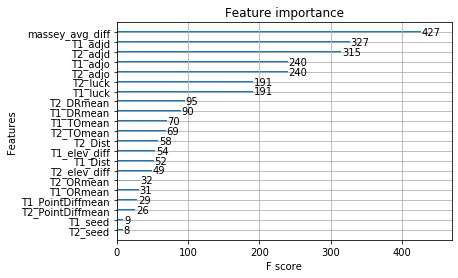

In [184]:
xgb.plot_importance(xgb_train)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [185]:
log_loss(y_train, xgb_train_prob)

0.4576650690340672

In [186]:
conv_train_preds_xgbr = []

for q in xgb_train_prob:
    if q > 0.5:
        conv_train_preds_xgbr.append(1)
    elif q < 0.5:
        conv_train_preds_xgbr.append(0)

In [187]:
accuracy_score(y_train, conv_train_preds_xgbr)

0.7972328244274809

Test Data

In [188]:
log_loss(y_true, xgb_true_prob)

0.46754040997197377

In [189]:
conv_preds_xgbr = []

for q in xgb_true_prob:
    if q > 0.5:
        conv_preds_xgbr.append(1)
    elif q < 0.5:
        conv_preds_xgbr.append(0)

In [190]:
accuracy_score(y_true, conv_preds_xgbr)

0.7313432835820896

In [191]:
confusion_matrix(y_true, conv_preds_xgbr)

array([[29,  9],
       [ 9, 20]])

### XGBoost Classifier

In [192]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_adjem,T1_adjo,T1_adjd,T1_luck,T2_adjem,T2_adjo,T2_adjd,T2_luck,T1_POM,T1_SAG,T1_MOR,T1_WLK,T1_massey_avg,T2_POM,T2_SAG,T2_MOR,T2_WLK,T2_massey_avg,T1_Trueskill,T2_Trueskill,T1_power_c,T2_power_c,pt_diff,win,ave_pt_diff,adjem_diff,adjo_diff,adjd_diff,luck_diff,pom_diff,massey_avg_diff,trueskill_diff,TO_diff,Block_diff,T1_top_25_wins,T2_top_25_wins,t25_wins_diff,T1_Dist,T2_Dist,T1_elev_diff,T2_elev_diff
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,16,16,0,-12.35,101.2,113.5,0.119,-10.45,98.3,108.7,0.037,65.138397,66.473193,64.898606,67.338190,65.962096,65.439336,66.106343,63.947499,67.151721,65.661225,22.040687,19.170459,0,0,8,1,-9.208046,-1.90,2.9,4.8,0.082,-0.300940,0.300871,2.870228,0.973563,0.766667,0,0,0,300.465553,935.811671,-450.876328,210.991872
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,1,16,-15,26.80,115.6,88.8,-0.007,1.57,101.1,99.5,0.019,94.318459,95.514642,93.380430,95.514642,94.682043,73.547610,72.542565,70.554232,72.897644,72.385513,38.633989,24.827440,1,0,29,1,10.309113,25.23,14.5,-10.7,-0.026,20.770848,22.296530,13.806549,0.716749,1.248768,2,0,2,591.222392,651.148244,543.465088,1240.325256
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,10,7,3,16.49,113.9,97.4,-0.014,16.72,110.9,94.1,0.005,84.559424,84.559424,86.458023,84.233153,84.952506,86.912819,

In [193]:
cols_used = ['T1_seed', 'T2_seed', 'T1_DRmean', 'T2_DRmean', 'T1_Dist', 'T2_Dist', 'T1_elev_diff', 
             'T2_elev_diff', 'T1_ORmean', 'T2_ORmean', 'T1_power_c', 'T2_power_c', 'T1_top_25_wins', 
             'T2_top_25_wins', 'T1_luck', 'T2_luck', 'T1_adjo', 'T2_adjo', 'T1_adjd', 'T2_adjd', 
             'massey_avg_diff', 'T1_FGM3mean', 'T2_FGM3mean', 'T1_FTMmean', 'T2_FTMmean', 'T1_FGMmean', 
             'T2_FGMmean', 'T1_Astmean', 'T2_Astmean', 'T1_Stlmean', 'T2_Stlmean', 'T1_Blkmean', 'T2_Blkmean', 
             'T1_PFmean', 'T2_PFmean']

X_train = tourney_data[cols_used]
y_train = tourney_data['win']
X_test = results_2019[cols_used]
y_true = results_2019['win']

# X_train = X_train.loc[(tourney_data['Season'] == (2018)) | (tourney_data['Season'] == (2017)) | 
#                       (tourney_data['Season'] == (2016))]

# y_train = y_train.loc[(tourney_data['Season'] == (2018)) | (tourney_data['Season'] == (2017)) | 
#                       (tourney_data['Season'] == (2016))]

In [194]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

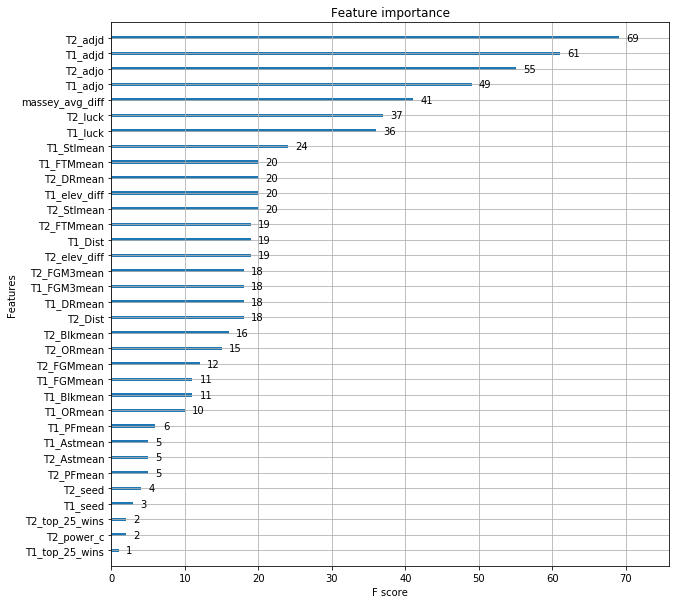

In [195]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [196]:
y_train_preds = model.predict(X_train)

In [197]:
# evaluate predictions
accuracy = accuracy_score(y_train, y_train_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.74%


In [198]:
y_pred = model.predict(X_test)
predictions_xgbc = [round(value) for value in y_pred]

In [199]:
y_pred_proba = model.predict_proba(X_test)

In [200]:
y_pred_proba = list(pd.DataFrame(y_pred_proba)[1])

In [201]:
log_loss(y_true, y_pred_proba)

0.4544936351768405

In [202]:
# evaluate predictions
accuracy = accuracy_score(y_true, predictions_xgbc)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.64%


In [203]:
confusion_matrix(y_true, predictions_xgbc)

array([[28, 10],
       [ 9, 20]])

### Combine Results, Train Data

Here I combined the results of each of the three models to see if incorporating all three would improve my predictions. 

In [204]:
len(y_train_preds)

2096

In [205]:
zippedList =  list(zip(y_train_preds, conv_train_preds_xgbr, y_train_preds))
comb_predictions_df = pd.DataFrame(zippedList, columns = ['LogReg1', 'XGBR', 'XGBC']) 
comb_predictions_df['total'] = comb_predictions_df['LogReg1'] + comb_predictions_df['XGBR'] + comb_predictions_df['XGBC']
comb_predictions_df['actual'] = tourney_data['win']
comb_predictions_df['Seed_diff'] = abs(tourney_data['Seed_diff'])
# comb_predictions_df = comb_predictions_df[comb_predictions_df['Seed_diff'] <= 5 ]
comb_predictions_df.head()

,LogReg1,XGBR,XGBC,total,actual,Seed_diff
0,1,1,1,3,1,0
1,1,1,1,3,1,15
2,0,0,0,0,1,3
3,0,0,0,0,1,5
4,1,1,1,3,1,1


In [206]:
# for i in list(range(len(comb_predictions_df))):
#     if comb_predictions_df['Seed_diff'][i] == 1:
#         comb_predictions_df['total'][i] = comb_predictions_df['XGBC'][i]
#     else:
#         comb_predictions_df['total'][i] = comb_predictions_df['LogReg1'][i]

In [207]:
for i in list(range(len(comb_predictions_df))):
    if comb_predictions_df['total'][i] >= 2:
        comb_predictions_df['total'][i] = 1
    else:
        comb_predictions_df['total'][i] = 0

In [208]:
accuracy_score(list(tourney_data['win']), list(comb_predictions_df['total']))

0.8673664122137404

In [209]:
confusion_matrix(list(tourney_data['win']), list(comb_predictions_df['total']))

array([[909, 139],
       [139, 909]])

### Combine Results, Test Data

In [210]:
zippedList =  list(zip(conv_preds_logreg_1, conv_preds_xgbr, predictions_xgbc))
comb_predictions_df = pd.DataFrame(zippedList, columns = ['LogReg1', 'XGBR', 'XGBC']) 
comb_predictions_df['total'] = comb_predictions_df['LogReg1'] + comb_predictions_df['XGBR'] + comb_predictions_df['XGBC']
comb_predictions_df['actual'] = results_2019['win']
comb_predictions_df['Seed_diff'] = abs(results_2019['Seed_diff'])
# comb_predictions_df = comb_predictions_df[comb_predictions_df['Seed_diff'] <= 5 ]
# comb_predictions_df[:60]

In [1409]:
# for i in list(range(len(comb_predictions_df))):
#     if comb_predictions_df['Seed_diff'][i] == 1:
#         comb_predictions_df['total'][i] = comb_predictions_df['XGBC'][i]
#     else:
#         comb_predictions_df['total'][i] = comb_predictions_df['LogReg1'][i]

In [1417]:
# for i in list(range(len(comb_predictions_df))):
#     if comb_predictions_df['total'][i] >= 2:
#         comb_predictions_df['total'][i] = 1
#     else:
#         comb_predictions_df['total'][i] = 0

In [1389]:
# comb_predictions_df[:60]

In [211]:
accuracy_score(list(results_2019['win']), list(comb_predictions_df['LogReg1']))

0.7761194029850746

In [212]:
confusion_matrix((results_2019['win']), list(comb_predictions_df['LogReg1']))

array([[32,  6],
       [ 9, 20]])

In [1229]:
# comb_predictions_df[:60]

In [1228]:
# comb_predictions_df[60:70]

In [1227]:
# results_2019[:35]

In [1226]:
# results_2019[35:70]

In [213]:
zippedList =  list(zip(y_preds_logreg, xgb_true_prob, y_pred_proba))
comb_proba_df = pd.DataFrame(zippedList, columns = ['LogReg1', 'XGBR', 'XGBC']) 
comb_proba_df['avg'] = round(comb_proba_df['LogReg1']*1 + comb_proba_df['XGBR']*0 + comb_proba_df['XGBC']*0)
comb_proba_df['actual'] = results_2019['win']
# comb_proba_df[:60]

In [214]:
accuracy_score(list(results_2019['win']), list(comb_proba_df['avg']))

0.7761194029850746

In [215]:
confusion_matrix(list(results_2019['win']), list(comb_proba_df['avg']))

array([[32,  6],
       [ 9, 20]])

Source: [Kaggle](https://www.kaggle.com/shahules/kenpom-2020)